In [1]:
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

In [2]:
ls "./data/"

 E 드라이브의 볼륨: 로컬 디스크
 볼륨 일련 번호: 5203-F739

 E:\3_2\AIProject\findMyBird\data 디렉터리

2018-12-12  오전 11:58    <DIR>          .
2018-12-12  오전 11:58    <DIR>          ..
2018-12-12  오전 11:58            44,248 Chicken (1).wav
2018-12-12  오전 11:58           176,444 Chicken (10).wav
2018-12-12  오전 11:58            22,094 Chicken (11).wav
2018-12-12  오전 11:58            88,244 Chicken (12).wav
2018-12-12  오전 11:58            44,144 Chicken (13).wav
2018-12-12  오전 11:58           176,444 Chicken (14).wav
2018-12-12  오전 11:58           176,444 Chicken (15).wav
2018-12-12  오전 11:58            22,094 Chicken (16).wav
2018-12-12  오전 11:58            11,070 Chicken (17).wav
2018-12-12  오전 11:58            11,122 Chicken (18).wav
2018-12-12  오전 11:58             8,140 Chicken (19).wav
2018-12-12  오전 11:58           384,114 Chicken (2).wav
2018-12-12  오전 11:58            44,248 Chicken (20).wav
2018-12-12  오전 11:58            22,094 Chicken (21).wav
2018-12-12  오전 11:58            88,244 Chicken (22).w

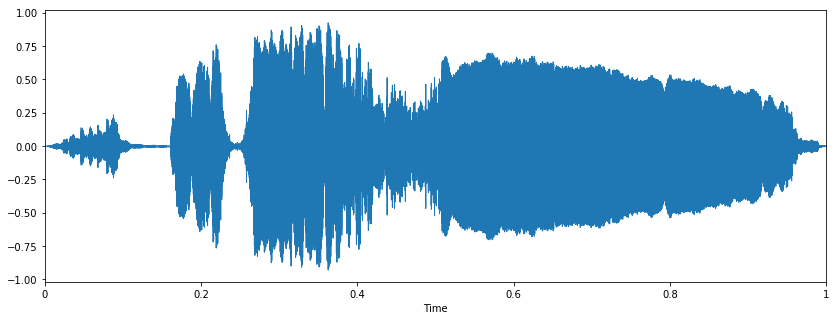

In [3]:
y, sr = librosa.load("./data/Chicken (1).wav")
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

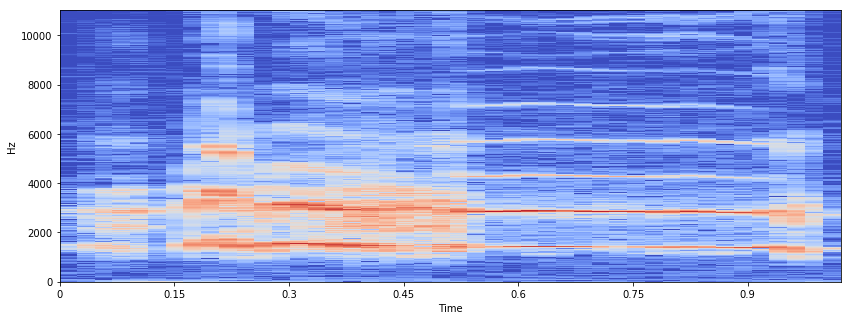

In [4]:
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

In [5]:
ipd.Audio('./data/Chicken (1).wav') # load a local WAV file

# 특징 추출 : MFCC

In [6]:
templist = []
label = [] # 원핫!

for i in range(1, 30):
    y, sr = librosa.load("./data/Owl ({}).wav".format(i))
    mfcc = librosa.feature.mfcc(y=y, sr=sr).T
    templist.append(mfcc)
    label.append(np.array([1,0,0,0]))

for i in range(1,17):
    y, sr = librosa.load("./data/Crow ({}).wav".format(i))
    mfcc = librosa.feature.mfcc(y=y, sr=sr).T
    templist.append(mfcc)
    label.append(np.array([0,0,1,0]))

for i in range(1, 13):
    y, sr = librosa.load("./data/Hawk ({}).wav".format(i))
    mfcc = librosa.feature.mfcc(y=y, sr=sr).T
    templist.append(mfcc)
    label.append(np.array([0,0,0,1]))

for i in range(1, 20):
    y, sr = librosa.load("./data/Chicken ({}).wav".format(i))
    mfcc = librosa.feature.mfcc(y=y, sr=sr).T
    templist.append(mfcc)
    label.append(np.array([0,1,0,0]))
dataset = np.asarray(templist)
print(dataset)
label = np.asarray(label)
print(label.shape)

[[[-4.48387175e+02  7.84992824e+01 -6.74737742e+00 ...  1.12978071e+00
    5.26709021e+00  8.67205455e+00]
  [-4.32083356e+02  8.50560446e+01 -1.74409843e+01 ... -1.46524608e+00
   -1.34146488e+00  3.58820583e+00]
  [-4.15602459e+02  8.70143651e+01 -3.39963487e+01 ...  1.19517384e-01
   -1.06338046e+01 -1.11383875e+00]
  ...
  [-3.67136277e+02  7.72863743e+01 -7.51759496e+01 ... -3.16988266e+00
   -1.78413144e+01  2.67148520e+01]
  [-4.26753095e+02  8.26589956e+01 -2.08707841e+01 ... -1.27972376e+01
    5.28740129e+00  1.79894674e+01]
  [-4.32293066e+02  8.45117298e+01 -8.28812800e+00 ... -1.75951491e+01
    5.30956239e+00  1.89147257e+01]]

 [[-4.32338278e+02  9.59514762e+01  8.88647252e-02 ...  8.90757638e+00
   -8.75938576e-01 -3.82257996e+00]
  [-4.08625721e+02  1.00336744e+02 -2.18821443e+01 ...  1.53101777e+01
    1.65675364e+00 -1.73494053e+01]
  [-4.00975239e+02  9.35406885e+01 -3.11993465e+01 ...  1.50538629e+01
   -8.31947057e-01 -2.19694450e+01]
  ...
  [-3.59764145e+02  8.3

# 신경망 모델

In [9]:
tf.reset_default_graph()
#########
# 옵션 설정
######
learning_rate = 0.0002
total_epoch = 200
batch_size = 1

n_input = mfcc.shape[1]
n_step = mfcc.shape[0]
n_hidden = 200
n_class = 4

#########
# 신경망 모델 구성
######
global_step = tf.Variable(0, trainable=False, name='global_step')

X = tf.placeholder(tf.float32, [None, n_step, n_input])
Y = tf.placeholder(tf.float32, [None, n_class])

with tf.name_scope('Layer'):
    W = tf.Variable(tf.random_normal([n_hidden, n_class]))
    b = tf.Variable(tf.random_normal([n_class]))

# RNN 에 학습에 사용할 셀을 생성합니다
# LSTM 셀을 사용하였습니다.

cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)

# RNN 신경망을 생성합니다
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

outputs = tf.transpose(outputs, [1, 0, 2])
outputs = outputs[-1]
with tf.name_scope('output'):
    model = tf.matmul(outputs, W) + b

with tf.name_scope('optimizer'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=Y))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost, global_step=global_step)
    tf.summary.scalar('cost', cost)

#########
# 신경망 모델 학습
######
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables())

merged = tf.summary.merge_all()
writer = tf.summary.FileWriter('./logs', sess.graph)
total_batch = len(dataset) #int(mnist.train.num_examples/batch_size)


# 신경망 학습 

In [11]:

for epoch in range(total_epoch):
    total_cost = 0

    for i in range(total_batch):
        batch_xs, batch_ys = (dataset[i], np.array([label[i]]))
        # X 데이터를 RNN 입력 데이터에 맞게 [batch_size, n_step, n_input] 형태로 변환합니다.
        batch_xs = batch_xs.reshape((batch_size, n_step, n_input))

        _, cost_val = sess.run([optimizer, cost],
                               feed_dict={X: batch_xs, Y: batch_ys})
        total_cost += cost_val

    print('Epoch:', '%04d' % (epoch + 1),
          'Avg. cost =', '{}'.format(total_cost / total_batch))
    
    summary = sess.run(merged, feed_dict={X:batch_xs, Y:batch_ys})
    writer.add_summary(summary, global_step=sess.run(global_step))

print('최적화 완료!')


Epoch: 0001 Avg. cost = 3.1924181771618776
Epoch: 0002 Avg. cost = 1.7903778849527279
Epoch: 0003 Avg. cost = 1.1280113367371853
Epoch: 0004 Avg. cost = 0.5880933440041286
Epoch: 0005 Avg. cost = 0.25388842267507006
Epoch: 0006 Avg. cost = 0.17122984725732462
Epoch: 0007 Avg. cost = 0.10246934896158084
Epoch: 0008 Avg. cost = 0.07734132831731251
Epoch: 0009 Avg. cost = 0.06359429920717287
Epoch: 0010 Avg. cost = 0.05217816346557332
Epoch: 0011 Avg. cost = 0.04361499944010766
Epoch: 0012 Avg. cost = 0.035941451801208085
Epoch: 0013 Avg. cost = 0.03017989246417959
Epoch: 0014 Avg. cost = 0.02495846819257215
Epoch: 0015 Avg. cost = 0.020120791995742893
Epoch: 0016 Avg. cost = 0.016710171608661097
Epoch: 0017 Avg. cost = 0.014439652604646892
Epoch: 0018 Avg. cost = 0.01288343907160532
Epoch: 0019 Avg. cost = 0.011623031745102708
Epoch: 0020 Avg. cost = 0.010562212681957374
Epoch: 0021 Avg. cost = 0.009556560275254205
Epoch: 0022 Avg. cost = 0.008595233354215356
Epoch: 0023 Avg. cost = 0.00

Epoch: 0179 Avg. cost = 7.158590278216455e-06
Epoch: 0180 Avg. cost = 6.995469805952319e-06
Epoch: 0181 Avg. cost = 6.794711574673479e-06
Epoch: 0182 Avg. cost = 6.658255818505297e-06
Epoch: 0183 Avg. cost = 6.408874918481376e-06
Epoch: 0184 Avg. cost = 6.2112457062113435e-06
Epoch: 0185 Avg. cost = 5.997940151378077e-06
Epoch: 0186 Avg. cost = 5.852073635973684e-06
Epoch: 0187 Avg. cost = 5.649745847018033e-06
Epoch: 0188 Avg. cost = 5.485057841001974e-06
Epoch: 0189 Avg. cost = 5.292139563158123e-06
Epoch: 0190 Avg. cost = 5.143137357496573e-06
Epoch: 0191 Avg. cost = 4.892181431328056e-06
Epoch: 0192 Avg. cost = 4.550249767619693e-06
Epoch: 0193 Avg. cost = 4.377718451415173e-06
Epoch: 0194 Avg. cost = 4.227145168917745e-06
Epoch: 0195 Avg. cost = 4.075001992544601e-06
Epoch: 0196 Avg. cost = 3.927564171060806e-06
Epoch: 0197 Avg. cost = 3.7769890160027922e-06
Epoch: 0198 Avg. cost = 3.5636730612546777e-06
Epoch: 0199 Avg. cost = 3.3707468903094493e-06
Epoch: 0200 Avg. cost = 3.2233

## 모델 저장 , 불러오기

In [51]:
# saver.save(sess, './model/lstm.ckpt', global_step=global_step)

'./model/lstm.ckpt-15200'

In [16]:
ckpt = tf.train.get_checkpoint_state('./model')
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    
    saver.restore(sess, ckpt.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from ./model\lstm.ckpt-15200


# 모델 테스트

## 정확도 측정

In [12]:
templist = []
test_label = [] # 원핫!

for i in range(30, 38):
    y, sr = librosa.load("./data/Owl ({}).wav".format(i))
    mfcc = librosa.feature.mfcc(y=y, sr=sr).T
    templist.append(mfcc)
    test_label.append(np.array([1,0,0,0]))
test_dataset = np.asarray(templist)

for i in range(17, 20):
    y, sr = librosa.load("./data/Crow ({}).wav".format(i))
    mfcc = librosa.feature.mfcc(y=y, sr=sr).T
    templist.append(mfcc)
    test_label.append(np.array([0,0,1,0]))
test_dataset = np.asarray(templist)

for i in range(13, 16):
    y, sr = librosa.load("./data/Hawk ({}).wav".format(i))
    mfcc = librosa.feature.mfcc(y=y, sr=sr).T
    templist.append(mfcc)
    test_label.append(np.array([0,0,0,1]))
test_dataset = np.asarray(templist)

for i in range(20, 24):
    y, sr = librosa.load("./data/Chicken ({}).wav".format(i))
    mfcc = librosa.feature.mfcc(y=y, sr=sr).T
    templist.append(mfcc)
    test_label.append(np.array([0,1,0,0]))
test_dataset = np.asarray(templist)


test_label = np.asarray(test_label)


In [17]:
np.argmax(sess.run(model, feed_dict={X:test_dataset}), axis=1)

array([0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 1, 3, 3, 3, 1, 1, 1, 1], dtype=int64)

In [18]:
np.argmax(test_label, axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 3, 3, 1, 1, 1, 1], dtype=int64)

In [19]:
correct_prediction=tf.equal(np.argmax(sess.run(model, feed_dict={X:test_dataset}), axis=1),np.argmax(test_label, axis=1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
print("Testing Accuracy:", sess.run(accuracy))

Testing Accuracy: 0.8333333
